In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
include("../src/worker_fct.jl")
data_type = "cal";
set = "sim";
high_cut = 4;

In [2]:
base_path  = joinpath("../../waveforms/sim/", "wf")
base_path_AE  = joinpath("../../waveforms/sim/", "calib_AE")

calib_filepath = "../dicts/calib.json"
calib = JSON.parsefile(calib_filepath)
cut_lib_filepath = "../dicts/cut_lib.json"
cut_lib = JSON.parsefile(cut_lib_filepath)
AE_cal_filepath = "../dicts/AE_cal.json"
AE_cal = JSON.parsefile(AE_cal_filepath)
det_lib_filepath = "../dicts/det_lib.json"
det_lib = JSON.parsefile(det_lib_filepath)

photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2103.5, 2614.5]; # keV

In [3]:
# Done: 0:4, 11:26, 30:35
ch = 0
ch_str = lpad(ch, 2, "0");
plots_path = joinpath("../plots/sim/",  ch_str * "-" * ctn[ch] * "/" *set)
if !haskey(calib, ctn[ch])
    calib[ctn[ch]] = Dict()
    calib[ctn[ch]]["data"] = Dict()
    calib[ctn[ch]]["sim"] = Dict()
end

# Load Data & calculate A and E

In [ ]:
filepaths = glob(joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "-*.h5"))
data = Table(A = [], E = [], energy = [])
@showprogress for filepath in filepaths
    append!(data, HDF5.h5open(filepath, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end)
end

In [ ]:
# filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * ".h5")
# !isdir(dirname(filepath)) ? mkpath(dirname(filepath)) : ""
# if !isfile(filepath)
#     numofele_A = 5
#     BackDelta5 = div(numofele_A,2)
#     ForwardDelta5 = isodd(numofele_A) ? div(numofele_A,2) : div(numofele_A,2) - 1
#     numofele_E = 201
#     BackDelta201 = div(numofele_E,2)
#     ForwardDelta201 = isodd(numofele_E) ? div(numofele_E,2) : div(numofele_E,2) - 1
    
#     files = glob(joinpath(base_path, ch_str * "-" * ctn[ch] * "/*/*.h5"));
#     data = Table(energy = [], A = [], E = [])
#     @showprogress 1 "Read data and calculate A & E for Ch$ch_str" for file in files
#         tmp = HDF5.h5open(file, "r") do h5f
#             LegendHDF5IO.readdata(h5f, "data")
#         end
#         A = []
#         E = []
#         test = tmp.waveform
#         return test
#         for wf in tmp.waveform
#             push!(A, maximum(movingaverage(diff(wf.value),numofele_A,BackDelta5,ForwardDelta5,3)))
#             push!(E, maximum(movingaverage(diff(wf.value),numofele_E,BackDelta201,ForwardDelta201,13)))
#         end
#         if size(tmp,1) > 1
#             append!(data, Table(energy = sum.(tmp.energy)*1000, A = A, E = E))
#         end
#     end
#     HDF5.h5open(filepath, "w") do h5f
#         LegendHDF5IO.writedata(h5f, "data", Table(
#             A = float.(data.A),
#             E = float.(data.E),
#             energy = float.(data.energy)
#         ))
#     end
#     data = nothing
# end
# data = HDF5.h5open(filepath, "r") do h5f
#     LegendHDF5IO.readdata(h5f, "data")
# end;

# First energy calibration

In [ ]:
maximum(data.E)

In [ ]:
photon_lines = [583.2, 727.3, 860.6, 1592.5, 1620.7, 2103.5, 2614.5]; # keV

before = 0.0:0.005:maximum(data.E)

h_uncal = fit(Histogram, float.(data.E), before)
p = plot(h_uncal, st=:step)
h_cal, h_deconv, peakPositions, threshold, c, c_precal = RadiationSpectra.calibrate_spectrum(h_uncal, photon_lines)      
p = plot(h_cal, st=:step, label="First calibration")
p = vline!(photon_lines, label="Photon lines")
p = plot!(xlabel="Energy [keV]", ylabel="Samples", title="Energy calibration Ch$ch_str", legend=false, framestyle=:box)
filename = joinpath(plots_path, "E_first-cal.pdf")
!isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
savefig(p, filename)
p

In [ ]:
calib[ctn[ch]][set]["events"]      = size(data,1)
calib[ctn[ch]][set]["first_cal"]   = c
calib[ctn[ch]][set]["uncal_range"] = Dict(
    "start" => before[1],
    "end" => before[end],
    "step" => round((before[end] - before[1]) / length(before), digits=4)
)
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end

### Fit peaks (without offset) - Auto

In [ ]:
c = calib[ctn[ch]][set]["first_cal"]
E = deepcopy(data.E) .* c
sigma = 1.8#
for i in eachindex(photon_lines)
    pl = photon_lines[i]
    rng_step  = 0.1

    if pl == 583.2
        rng_width = 15
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/13,
            σ = sigma,
            μ = pl,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end]),
            c = 1e2,
            d = 0.1,
            β = 0.9
        )
        ff = peak
    elseif pl == 727.3
        rng_width = 10
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/15,
            σ = sigma,
            μ = pl+0.35,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end]),
            c = 1e2,
            d = 0.1,
            β = 0.9
        )
        ff = peak
    elseif pl == 860.6
        rng_width = 10
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/25,
            σ = sigma,
            μ = pl-0.5,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end]),
            c = 0.5e2,
            d = 0.1,
            β = 0.9
        )
        ff = peak
    elseif pl == 1592.5
        rng_width = 15
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/30,
            σ = sigma,
            μ = pl-0.5,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end]),
            c = 1e1,
            d = 1,
            β = 0.4
        )
        ff = peak
    elseif pl == 1620.7
        rng_width = 10
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/25,
            σ = sigma+ 0.2,
            μ = pl,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end]),
            c = 1e1,
            d = 0.1,
            β = 0.9
        )
        ff = peak
    elseif pl == 2103.5
        rng_width = 15
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/27,
            σ = sigma,
            μ = pl,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end]),
            c = 5e1,
            d = 5.1,
            β = 1.9
        )
        ff = peak
    elseif pl == 2614.5
        rng_width = 15
        rng = pl-rng_width:rng_step:pl+rng_width
        h_peak = fit(Histogram, E, rng)
        p0 = (
            n = sum(h_peak.weights)/15,
            σ = sigma+0.2,
            μ = pl,
            bkg_l = mean(h_peak.weights[1:10]),
            bkg_r = mean(h_peak.weights[end-10:end])+0.5,
            c = 1e2,
            d = 5.1,
            β = 1.9
        )
        ff = peak
    end

    
    if pl == 583.2
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = p0.bkg_l/var..p0.bkg_l*var,
            bkg_r = p0.bkg_r/var..p0.bkg_r*var,
            c = p0.c/var..p0.c*2*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..2.0
        )
        ff = peak
    elseif pl == 727.3
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 0.75..p0.µ + 0.5,
            bkg_l = p0.bkg_l/var..p0.bkg_l*var,
            bkg_r = p0.bkg_r/var..p0.bkg_r*var,
            c = p0.c/var..p0.c*2*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..2.0
        )
        ff = peak
    elseif pl == 860.6
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = p0.bkg_l/var..p0.bkg_l*var,
            bkg_r = p0.bkg_r/var..p0.bkg_r*var,
            c = p0.c/var..p0.c*2*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..2.0
        )
        ff = peak
    elseif pl == 1592.5
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 1..p0.µ + 0.5,
            bkg_l = p0.bkg_l/var..p0.bkg_l*var,
            bkg_r = p0.bkg_r/var..p0.bkg_r*var,
            c = p0.c/var..p0.c*2*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..2.0
        )
        ff = peak
    elseif pl == 1620.7
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = p0.bkg_l/var..p0.bkg_l*var,
            bkg_r = p0.bkg_r/var..p0.bkg_r*var,
            c = p0.c/var..p0.c*2*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..2.0
        )
        ff = peak
    elseif pl == 2103.5
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = p0.bkg_l/var..p0.bkg_l*var,
            bkg_r = p0.bkg_r/var..p0.bkg_r*var,
            c = p0.c/var..p0.c*2*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..2
        )
        ff = peak
    elseif pl == 2614.5
        var = 1.5
        prior = NamedTupleDist(
            n = p0.n/var/10..p0.n*2*var,
            σ = p0.σ/var..p0.σ*var,
            μ = p0.µ - 0.5..p0.µ + 0.5,
            bkg_l = 0.1..p0.bkg_l*var,
            bkg_r = 0.1..p0.bkg_r*var,
            c = p0.c/var/10..p0.c*3*var,
            d = p0.d/var..p0.d*var,
            β = p0.β/var..14.0
    #         n2 = p0.n2/var/5..p0.n2*2,
    #         σ2 = p0.σ2/var..p0.σ2*var,
        )
        ff = peak
    end

    samples = try bat_fit(h_peak, ff, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=true);
        catch 
        IJulia.clear_output(true)
        @info("Second try - " * string(pl))
        try bat_fit(h_peak, ff, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=true);
            catch 
            IJulia.clear_output(true)
            @info("Last try - " * string(pl))
            try bat_fit(h_peak, ff, prior; nsamples=10^6, nchains=4, params_first=false, norm_expected=true);
                catch
                IJulia.clear_output(true)
                @info("Failed! - " * string(pl))
                continue
            end
        end
    end
    IJulia.clear_output(true)
    par, err = mean(samples), std(samples);
    
    x_fit = midpoints(h_peak.edges[1])
    y_fit = ff(x_fit, par)
    y_fit ./= sum(y_fit)
    y_fit .*= sum(h_peak.weights)
    p = plot(h_peak, st=:step, label="Cal. data", framestyle=:box);
    p = plot!(x_fit, y_fit, label="Bat fit");
    p = plot!(xlabel="Energy [keV]", ylabel="Samples/" * string(rng_step) * "keV");
    p = vline!([pl], label="Photon line");
    display(p)
    filename = joinpath(plots_path, "peaks/$pl keV line-first.pdf")
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    savefig(p, filename);
    !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
    !haskey(calib[ctn[ch]][set]["fits"], "peaks_first_cal") ? calib[ctn[ch]][set]["fits"]["peaks_first_cal"] = Dict() : ""
    calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)] = [par, err];
    open(calib_filepath, "w") do f
        JSON.print(f, calib, 4)
    end
end

In [ ]:
calib[ctn[ch]][set]["fits"]["peaks_first_cal"]

### Fit peaks (without offset) - Manual

In [ ]:
# i = 7

In [ ]:
# pl = photon_lines[i]
# rng_step  = 0.1

# c = calib[ctn[ch]][set]["first_cal"]
# E = data.E .* c
# sigma = 1.5#

# if pl == 583.2
#     rng_width = 15
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/13,
#         σ = sigma,
#         μ = pl,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end]),
#         c = 1e2,
#         d = 0.1,
#         β = 0.9
#     )
#     ff = peak
# elseif pl == 727.3
#     rng_width = 10
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/15,
#         σ = sigma,
#         μ = pl+0.35,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end]),
#         c = 1e2,
#         d = 0.1,
#         β = 0.9
#     )
#     ff = peak
# elseif pl == 860.6
#     rng_width = 10
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/25,
#         σ = sigma,
#         μ = pl-0.5,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end]),
#         c = 0.5e2,
#         d = 0.1,
#         β = 0.9
#     )
#     ff = peak
# elseif pl == 1592.5
#     rng_width = 15
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/30,
#         σ = sigma,
#         μ = pl-0.5,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end]),
#         c = 1e1,
#         d = 1,
#         β = 0.4
#     )
#     ff = peak
# elseif pl == 1620.7
#     rng_width = 10
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/25,
#         σ = sigma+ 0.2,
#         μ = pl,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end]),
#         c = 1e1,
#         d = 0.1,
#         β = 0.9
#     )
#     ff = peak
# elseif pl == 2103.5
#     rng_width = 15
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/27,
#         σ = sigma,
#         μ = pl,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end]),
#         c = 5e1,
#         d = 5.1,
#         β = 1.9
#     )
#     ff = peak
# elseif pl == 2614.5
#     rng_width = 15
#     rng = pl-rng_width:rng_step:pl+rng_width
#     h_peak = fit(Histogram, E, rng)
#     p0 = (
#         n = sum(h_peak.weights)/15,
#         σ = sigma+0.2,
#         μ = pl,
#         bkg_l = mean(h_peak.weights[1:10]),
#         bkg_r = mean(h_peak.weights[end-10:end])+0.5,
#         c = 1e2,
#         d = 5.1,
#         β = 1.9
#     )
#     ff = peak
# #     rng_width = 20
# #     rng = pl-rng_width:rng_step:pl+rng_width
# #     h_peak = fit(Histogram, E, rng)
# #     p0 = (
# #         n = sum(h_peak.weights)/18,
# #         σ = sigma+0.07,
# #         μ = pl+0.8,
# #         bkg_l = mean(h_peak.weights[1:10]),
# #         bkg_r = mean(h_peak.weights[end-10:end]),
# #         c = 0.5e2,
# #         d = 0.05,
# #         β = 1.9,
# #         n2 = 2e4,
# #         σ2 = 2.67
# #     )
# #     p0 = (
# #         n = 3.0e4,
# #         σ = 1.93,
# #         μ = 2615.0 +0.3,
# #         bkg_l = mean(h_peak.weights[1:10]),
# #         bkg_r = mean(h_peak.weights[end-10:end]),
# #         c = 1e3,
# #         d = 1,
# #         β = 3.29,
# #         n2 = 1.5e4,
# #         σ2 = 3.5
# #     )
# #     ff = broad_peak
# end



# x_fit = midpoints(h_peak.edges[1])
# y_fit = ff(x_fit, p0)
# y_fit ./= sum(y_fit)
# y_fit .*= sum(h_peak.weights)
# println(p0)
# p = plot(h_peak, st=:step, label="Cal. data");
# p = plot!(x_fit, y_fit, label="Bat fit");
# p = plot!(xlabel="Energy [keV]", ylabel="Samples", title="$pl keV line Ch$ch_str", legend=:outertop, size=(1000,600));
# p = vline!([pl], label="Photon line");
# p

In [ ]:
# if pl == 583.2
#     var = 1.2
#     prior = NamedTupleDist(
#         n = p0.n/var..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 0.5..p0.µ + 0.5,
#         bkg_l = p0.bkg_l/var..p0.bkg_l*var,
#         bkg_r = p0.bkg_r/var..p0.bkg_r*var,
#         c = p0.c/var..p0.c*2*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..2.0
#     )
#     ff = peak
# elseif pl == 727.3
#     var = 1.25
#     prior = NamedTupleDist(
#         n = p0.n/var..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 0.75..p0.µ + 0.5,
#         bkg_l = p0.bkg_l/var..p0.bkg_l*var,
#         bkg_r = p0.bkg_r/var..p0.bkg_r*var,
#         c = p0.c/var..p0.c*2*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..2.0
#     )
#     ff = peak
# elseif pl == 860.6
#     var = 1.25
#     prior = NamedTupleDist(
#         n = p0.n/var..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 0.5..p0.µ + 0.5,
#         bkg_l = p0.bkg_l/var..p0.bkg_l*var,
#         bkg_r = p0.bkg_r/var..p0.bkg_r*var,
#         c = p0.c/var..p0.c*2*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..2.0
#     )
#     ff = peak
# elseif pl == 1592.5
#     var = 1.3
#     prior = NamedTupleDist(
#         n = p0.n/var..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 1..p0.µ + 0.5,
#         bkg_l = p0.bkg_l/var..p0.bkg_l*var,
#         bkg_r = p0.bkg_r/var..p0.bkg_r*var,
#         c = p0.c/var..p0.c*2*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..2.0
#     )
#     ff = peak
# elseif pl == 1620.7
#     var = 1.3
#     prior = NamedTupleDist(
#         n = p0.n/var..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 0.5..p0.µ + 0.5,
#         bkg_l = p0.bkg_l/var..p0.bkg_l*var,
#         bkg_r = p0.bkg_r/var..p0.bkg_r*var,
#         c = p0.c/var..p0.c*2*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..2.0
#     )
#     ff = peak
# elseif pl == 2103.5
#     var = 1.25
#     prior = NamedTupleDist(
#         n = p0.n/var..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 0.5..p0.µ + 0.5,
#         bkg_l = p0.bkg_l/var..p0.bkg_l*var,
#         bkg_r = p0.bkg_r/var..p0.bkg_r*var,
#         c = p0.c/var..p0.c*2*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..2
#     )
#     ff = peak
# elseif pl == 2614.5
#     var = 1.5
#     prior = NamedTupleDist(
#         n = p0.n/var/10..p0.n*2*var,
#         σ = p0.σ/var..p0.σ*var,
#         μ = p0.µ - 0.5..p0.µ + 0.5,
#         bkg_l = 0.1..p0.bkg_l*var,
#         bkg_r = 0.1..p0.bkg_r*var,
#         c = p0.c/var/10..p0.c*3*var,
#         d = p0.d/var..p0.d*var,
#         β = p0.β/var..14.0
# #         n2 = p0.n2/var/5..p0.n2*2,
# #         σ2 = p0.σ2/var..p0.σ2*var,
#     )
#     ff = peak
# end

# samples = try bat_fit(h_peak, ff, prior; nsamples=5*10^4, nchains=4, params_first=false, norm_expected=true);
#     catch 
#     IJulia.clear_output(true)
#     @info("Second try")
#     try bat_fit(h_peak, ff, prior; nsamples=5*10^5, nchains=4, params_first=false, norm_expected=true);
#         catch 
#         IJulia.clear_output(true)
#         @info("Last try")
#         try bat_fit(h_peak, ff, prior; nsamples=10^6, nchains=4, params_first=false, norm_expected=true);
#             catch
#             IJulia.clear_output(true)
#             @info("Failed!")
#             fail = true
#         end
#     end
# end
# IJulia.clear_output(true)
# par, err = mean(samples), std(samples);
# par

In [ ]:
# x_fit = midpoints(h_peak.edges[1])
# y_fit = ff(x_fit, par)
# y_fit ./= sum(y_fit)
# y_fit .*= sum(h_peak.weights)
# p = plot(h_peak, st=:step, label="Cal. data");
# p = plot!(x_fit, y_fit, label="Bat fit");
# p = plot!(xlabel="Energy [keV]", ylabel="Samples", title="$pl keV line Ch$ch_str", legend=:outertop, size=(1000,600));
# p = vline!([pl], label="Photon line");
# p

In [ ]:
# filename = joinpath(plots_path, "peaks/$pl keV line-first.png")
# !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
# savefig(p, filename);
# !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
# !haskey(calib[ctn[ch]][set]["fits"], "peaks_first_cal") ? calib[ctn[ch]][set]["fits"]["peaks_first_cal"] = Dict() : ""
# calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)] = [par, err];
# open(calib_filepath, "w") do f
#     JSON.print(f, calib, 4)
# end

# Linear energy calibration for offset

In [ ]:
calib = JSON.parsefile(calib_filepath)
pos_pl  = []
pos     = []
pos_err = []
c = calib[ctn[ch]][set]["first_cal"]
for (k,v) in calib[ctn[ch]][set]["fits"]["peaks_first_cal"]
    push!(pos_pl, parse(Float64, k))
    push!(pos, v[1]["μ"] / c)
    push!(pos_err, v[2]["μ"] / c)
end
p0 = [c, .0]
f = curve_fit(linmodel, pos, pos_pl, p0)
par = f.param
err = margin_error(f)
p = scatter(pos, pos_pl, xerr=pos_err, label="")
x = 0:0.5:maximum(pos)
p = plot!(x, linmodel(x, par), label=string(round(par[1], digits=2)) * " E + " * string(round(par[2], digits=2)) * " keV")
p = plot!(size=(800,600), fmt=:svg, title="Ch" * ch_str * "-" * ctn[ch]* " - Linear E calibration")
p = plot!(xlabel="E uncalibrated", ylabel="Energy [keV]", legend=:bottomright)
filename = joinpath(plots_path, "linear-energy-fit.pdf")
savefig(p, filename)
display(p)
calib[ctn[ch]][set]["lin_cal"] = [par, err]
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end

In [ ]:
E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
h_cal = fit(Histogram, E, 300:1:3000)
p = plot(h_cal, st=:step, label="", yaxis=:log)
p = vline!(photon_lines, label="")
p = plot!(size=(800,600), ylabel="Samples", xlabel="Energy [keV]")

### Fit peaks (with offset)

In [ ]:
# calib = JSON.parsefile(calib_filepath)
# overwrite = true
# E = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
# @showprogress 1 "Ch" * ch_str * " | Fit peaks using calibration with offset..." for pl in photon_lines
#     process = true
#     if haskey(calib[ctn[ch]][set]["fits"], "peaks_cal")
#         if haskey(calib[ctn[ch]][set]["fits"]["peaks_cal"], string(pl))
#             if length(calib[ctn[ch]][set]["fits"]["peaks_cal"][string(pl)][1]) > 1
#                 if length(calib[ctn[ch]][set]["fits"]["peaks_cal"][string(pl)][2]) > 1
#                     process = false
#                 end
#             end
#         end
#     end
#     if overwrite
#         process = true
#     end
#     if process
#         rng_step  = 0.1
#         rng_width = 20
#         c = calib[ctn[ch]][set]["first_cal"]
#         rng = pl-rng_width:rng_step:pl+rng_width
#         h_peak = fit(Histogram, E, rng)


#         bkg_l_mean = mean(h_peak.weights[1:20])+0.5
#         bkg_r_mean = mean(h_peak.weights[end-20:end])+0.5

# #         if pl == 2614.5
# #             old = calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)][1]
# #             var = 1.25
# #             prior = NamedTupleDist(
# #                 n = old["n"]/var..old["n"]*var,
# #                 σ = old["σ"]/var..old["σ"]*var,
# #                 μ = pl-1.5..pl+0.75,
# #                 bkg_l = old["bkg_l"]/var..old["bkg_l"]*var,
# #                 bkg_r = old["bkg_r"]/var..old["bkg_r"]*var,
# #                 c = old["c"]/var..old["c"]*var,
# #                 d = old["d"]/var..old["d"]*var,
# #                 β = old["β"]/var..old["β"]*var,
# #                 n2 = old["n2"]/var..old["n2"]*var,
# #                 σ2 = old["σ2"]/var..old["σ2"]*var
# #             )
# #             ff = broad_peak
# #         else
#             old = calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)][1]
#             var = 1.2
#             prior = NamedTupleDist(
#                 n = old["n"]/var..old["n"]*var,
#                 σ = old["σ"]/var..old["σ"]*var,
#                 μ = pl-1.5..pl+1.5,
#                 bkg_l = old["bkg_l"]/var..old["bkg_l"]*var,
#                 bkg_r = old["bkg_r"]/var..old["bkg_r"]*var,
#                 c = old["c"]/var..old["c"]*var,
#                 d = old["d"]/var..old["d"]*var,
#                 β = old["β"]/var..old["β"]*var
#             )
#             ff = peak
# #         end
#         fail = false
#         @info(string(pl) * " keV | second cal")
#         samples = try bat_fit(h_peak, ff, prior; nsamples=5*10^4, nchains=4, params_first=false)
#             catch 
#             try bat_fit(h_peak, ff, prior; nsamples=5*10^5, nchains=4, params_first=false)
#                 catch 
#                 try bat_fit(h_peak, ff, prior; nsamples=10*10^5, nchains=4, params_first=false)
#                     catch 
#                     fail = true
#                 end
#             end
#         end
#         if fail == false
#             v = mean(samples)
#             x_fit = midpoints(h_peak.edges[1])
#             y_fit = ff(x_fit, v)
#             y_fit ./= sum(y_fit)
#             y_fit .*= sum(h_peak.weights)
#             p = plot(h_peak, st=:step, label="Cal. data");
#             p = plot!(x_fit, y_fit, label="Bat fit");
#             p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box);
#             p = vline!([pl], label="Photon line");
#             filename = joinpath(plots_path, "peaks/$pl keV line-linear.pdf")
#             !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
#             savefig(p, filename);
#             IJulia.clear_output(true)
#             display(p)
#             !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
#             !haskey(calib[ctn[ch]][set]["fits"], "peaks_cal") ? calib[ctn[ch]][set]["fits"]["peaks_cal"] = Dict() : ""
#             calib[ctn[ch]][set]["fits"]["peaks_cal"][string(pl)] = [mode(samples), std(samples)]
#         else
#             @info("Fail for $pl keV line")
#             !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
#             !haskey(calib[ctn[ch]][set]["fits"], "peaks_cal") ? calib[ctn[ch]][set]["fits"]["peaks_cal"] = Dict() : ""
#             calib[ctn[ch]][set]["fits"]["peaks_cal"][string(pl)] = [[], []]
#         end
#         open(calib_filepath, "w") do f
#             JSON.print(f, calib, 4)
#         end
#     end
# end

### Smearing

Here, the energy is smeared and stored in AE_calibrated_smeared.h5 next to the previous AE.h5 file

Afterwards, the data table is overwritten with the smeared data

In [ ]:
calib = JSON.parsefile(calib_filepath)
smearing_dict = JSON.parsefile("../dicts/smearing.json")["Gauss"]
p0 = [smearing_dict[string(ch)]["params"]["0"], smearing_dict[string(ch)]["params"]["1"], smearing_dict[string(ch)]["params"]["2"]]
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
if !isfile(filepath)

    #
    ## read normal AE data
    filepaths = glob(joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "-*.h5"))
    data = Table(A = [], E = [], energy = [])
    for filepath in filepaths
        append!(data, HDF5.h5open(filepath, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end)
    end
    #
    ## calibrate and smear energy
    E_unsmeared = linmodel(data.E, calib[ctn[ch]][set]["lin_cal"][1])
    E = []
    @showprogress "Smearing energy... " for e in E_unsmeared
        d = Normal(0, sqrt_fct(e,p0))
        push!(E, e + rand(d))
    end

    #
    ## Create new table
    data_smeared = Table(A=float.(data.A), E=float.(E), E_unsmeared=float.(E_unsmeared), E_uncal=float.(data.E), energy=float.(data.energy))
    filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
    HDF5.h5open(filepath, "w") do h5f
        LegendHDF5IO.writedata(h5f, "data", data_smeared)
    end
end
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
data = HDF5.h5open(filepath, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end;

# Fits after smearing

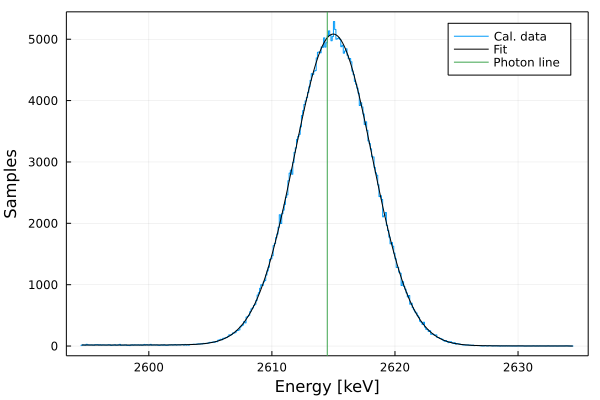

Ch35 | Fit peaks after smearing... 100%|████████████████| Time: 0:00:45


In [6]:
fails = Dict()
calib = JSON.parsefile(calib_filepath)
overwrite = true

ch = 0
if !ctb[ch] || ch in [5,6,7]
    continue
end
ch_str = lpad(ch, 2, "0")
filepath = joinpath(base_path_AE, ch_str * "-" * ctn[ch] * "_AE_calibrated_smeared.h5")
data = HDF5.h5open(filepath, "r") do h5f
    LegendHDF5IO.readdata(h5f, "data")
end;
E = deepcopy(data.E)
@showprogress 1 "Ch" * ch_str * " | Fit peaks after smearing... " for pl in photon_lines
    rng_step  = 0.1
    rng_width = 20
    c = calib[ctn[ch]][set]["first_cal"]
    rng = pl-rng_width:rng_step:pl+rng_width
    h_peak = fit(Histogram, E, rng)


    bkg_l_mean = mean(h_peak.weights[1:20])+0.5
    bkg_r_mean = mean(h_peak.weights[end-20:end])+0.5

    old = calib[ctn[ch]][set]["fits"]["peaks_first_cal"][string(pl)][1]
    var = 1.2
    prior = NamedTupleDist(
        n = old["n"]/var..old["n"]*var,
        σ = old["σ"]/var..old["σ"]*var+0.25,
        μ = pl-1.5..pl+1.5,
        bkg_l = old["bkg_l"]/var..old["bkg_l"]*var,
        bkg_r = old["bkg_r"]/var..old["bkg_r"]*var,
        c = old["c"]/var..old["c"]*var,
        d = old["d"]/var..old["d"]*var,
        β = old["β"]/var..old["β"]*var
    )

    @info(string(pl) * " keV | smearing cal")
    samples = try bat_fit(h_peak, peak, prior; nsamples=5*10^4, nchains=4, params_first=false)
    catch 
        IJulia.clear_output(true)
        try bat_fit(h_peak, peak, prior; nsamples=5*10^5, nchains=4, params_first=false)
        catch 
            IJulia.clear_output(true)
            try bat_fit(h_peak, peak, prior; nsamples=10*10^5, nchains=4, params_first=false)
            catch
                IJulia.clear_output(true)
                !haskey(fails, ctn[ch]) ? fails[ctn[ch]] = [] : ""
                push!(fails[ctn[ch]], pl)
                continue
            end
        end
    end
    v = mean(samples)
    x_fit = midpoints(h_peak.edges[1])
    y_fit = peak(x_fit, v)
    y_fit ./= sum(y_fit)
    y_fit .*= sum(h_peak.weights)
    p = plot(h_peak, st=:step, label="Cal. data");
    p = plot!(x_fit, y_fit, label="Fit", color=:black);
    p = plot!(xlabel="Energy [keV]", ylabel="Samples", framestyle=:box);
    p = vline!([pl], label="Photon line");
    filename = joinpath(plots_path, "peaks/$pl keV line-smeared.pdf")
    !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
    savefig(p, filename);
    IJulia.clear_output(true)

    display(p)
#     return
    !haskey(calib[ctn[ch]][set], "fits") ? calib[ctn[ch]][set]["fits"] = Dict() : ""
    !haskey(calib[ctn[ch]][set]["fits"], "peaks_cal_smeared") ? calib[ctn[ch]][set]["fits"]["peaks_cal_smeared"] = Dict() : ""
    calib[ctn[ch]][set]["fits"]["peaks_cal_smeared"][string(pl)] = [mode(samples), std(samples)]
    open(calib_filepath, "w") do f
        JSON.print(f, calib, 4)
    end
end

# A/E calibration

In [ ]:
calib = JSON.parsefile(calib_filepath)
E = deepcopy(data.E)
A = deepcopy(data.A)
AoE = A ./ E
h = fit(Histogram, AoE, 0:0.0001:0.3)
AE_norm = h.edges[1][findfirst(x->x == maximum(h.weights), h.weights)]
AoE ./= AE_norm
h = fit(Histogram, AoE, 0:0.001:1.5)
calib[ctn[ch]][set]["AE_norm"] = AE_norm
open(calib_filepath, "w") do f
    JSON.print(f, calib, 4)
end
p = plot(h, st=:step, label="All events")
p = plot!(xlabel="Normalized A/E [a.u.]", ylabel="Samples", title="Ch$ch_str", legend=:outertop, size=(1000,600))
filename = joinpath(plots_path, "AoverE_all-events_norm.pdf")
savefig(p, filename)
display(p)